# Series 7: Non-Negative Matrix Factorization

## Problem 2 (Implementing NMF for Image Analysis)

In [4]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

### Data wrangling

In [5]:
image_dir = "data/CroppedYale/"

files = os.listdir(image_dir)
n = len(files)
print("Loading " + str(n) + " images")

imgs = [Image.open(image_dir + files[i]) for i in range(n)]

Loading 38 images


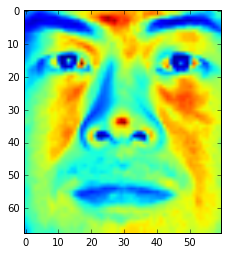

In [6]:
plt.imshow(imgs[1]) # Display first image

In [7]:
# Assume all images have the same size
img0 = imgs[0]
width, height = img0.size

# Compute input matrix X
X_list = [np.ravel(imgs[i].getdata()) for i in range(n)]
X = np.array(X_list, dtype=np.float32)
print(X.shape)

(38, 4080)


## Alternating least-squares

Algorithm outline, as highlighted in [1]:

```
W = rand(m, k)    # random dense matrix, non-negative
for i = 1 : maxiter
    H = Solve for H in W^T W H = W^T A
    H[H < 0] = 0
    
    W = Solve for W in H H^T W^T = H A^T
    W[W < 0] = 0
```

[1]: Berry, Michael W., et al. "Algorithms and applications for approximate nonnegative matrix factorization." Computational statistics & data analysis 52.1 (2007): 155-173.

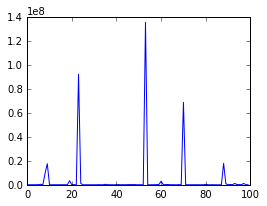

In [148]:
k = 50
epochs = 100
errors = np.zeros(epochs)

np.random.seed(0x777)

N, M = X.shape
# Correspondence with Berry et al.'s notation:
# U = W
# V = H
# X = A
U = np.random.random([N, k])
V = np.random.random([k, M])

for epoch in range(epochs):
    A_V = np.dot(U.T, U)
    B_V = np.dot(U.T, X)
    V_new, _, _, _ = np.linalg.lstsq(A_V, B_V)
    V_new[V_new < 0] = 0
    
    # Use the new V to update U.
    A_U = np.dot(V_new, V_new.T)
    B_U = np.dot(V_new, X.T)
    U_new, _, _, _ = np.linalg.lstsq(A_U, B_U)
    U_new[U_new < 0] = 0
    # The equation solves for the transpose of U, so let's
    # un-transpose it now.
    U_new = U_new.T
    
    # Keep track of the error curve
    reconstructed_X = np.dot(U, V)
    error = np.linalg.norm(X - reconstructed_X)
    errors[epoch] = error
    
    U = U_new
    V = V_new
    
rcParams['figure.figsize'] = 4, 3
plt.plot(np.arange(epochs), errors)

(50, 4080)


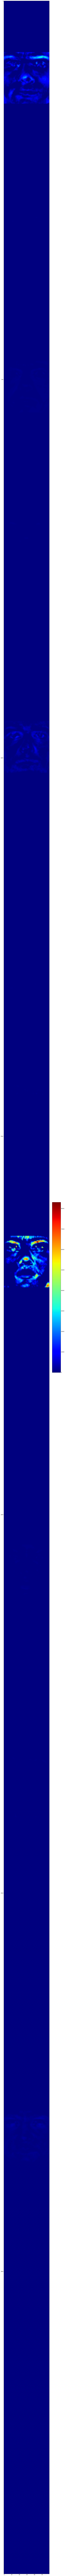

In [149]:
# Plot the resulting images stored in the columns of V
from pylab import rcParams
MAX_IMAGES_TO_SHOW = 100

# Big images **will** take some time to render.
rcParams['figure.figsize'] = 10, 6 * MAX_IMAGES_TO_SHOW
print(V.shape)
new_images_stacked = np.reshape(V[:MAX_IMAGES_TO_SHOW,:], (-1, width))
fig1 = plt.figure()
# plt.imshow(new_images_stacked, cmap='Greys')
plt.imshow(new_images_stacked)
plt.colorbar()

# Using sklearn (a.k.a. cheating)

Note: results aren't really much better than the hand-crafted approach.

In [122]:
from sklearn.decomposition import NMF 

# init='nndsvdar' or 'random'
nmf = NMF(n_components=10, max_iter=200)
nmf.fit(X)

print(nmf.reconstruction_err_, "in", nmf.n_iter_, "iterations.")

6887.940470745501 in 199 iterations.


In [123]:
components = nmf.components_
components.shape

(10, 4080)

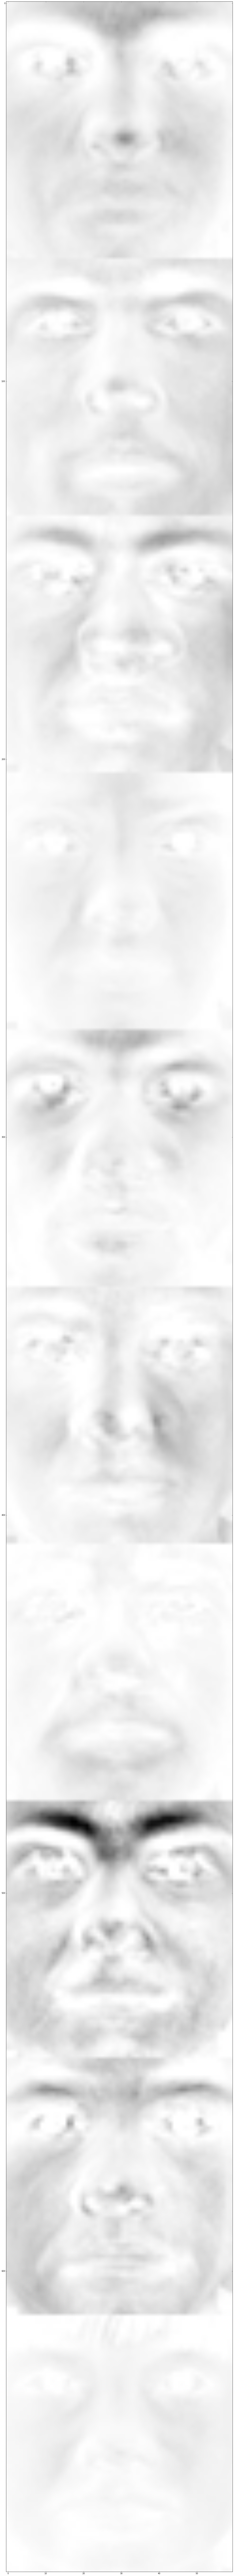

In [124]:
c2s = 38
cheat_images_stacked = np.reshape(components[:c2s,:],
                                  (-1, width))

rcParams['figure.figsize'] = 20, 8 * c2s
plt.imshow(cheat_images_stacked, cmap="Greys")